In [1]:
# Cell 1: 라이브러리 & 설정
import os
import json
import re
import torch
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoTokenizer, AutoModelForCausalLM

# ⚙️ 설정값
INPUT_FILE = "project_full_context.txt"
OUTPUT_JSON = "project_flows.json"
MODEL_ID = "Qwen/Qwen2.5-Coder-1.5B-Instruct"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 실행 환경: {device.upper()}")

c:\Pyg\Projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 실행 환경: CUDA


In [2]:
# Cell 2: 모델 로딩
print(f"🔄 모델 로딩 시작... ({MODEL_ID})")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

print("✅ 모델 장착 완료!")

🔄 모델 로딩 시작... (Qwen/Qwen2.5-Coder-1.5B-Instruct)


`torch_dtype` is deprecated! Use `dtype` instead!


✅ 모델 장착 완료!


In [4]:
# Cell 3: 프롬프트 정의 (초보자 멘토링 & 데이터 흐름 추적 강화)
SYSTEM_PROMPT = """
You are a 'Senior Coding Mentor' for beginners.
Your goal is to visualize the **Lifecycle of Data** and **Execution Flow** across multiple files.

### YOUR TASK
1.  **Trace the Data**: If a user clicks 'Signup', follow the variables (id, password, etc.) from the Router -> Controller -> Service -> Database.
2.  **Explain the 'Return'**: Beginners struggle to understand what comes back from a function. Explicitly state what is returned (e.g., "Returns a User Object" or "Returns a True/False flag").
3.  **Beginner-Friendly Logic**: Don't just say "Hash password". Say "Security Step: We convert the plain password into a scrambled code (Hash) so hackers can't read it."

### OUTPUT FORMAT (JSON ONLY)
{
  "project_summary": "A high-level summary of how the files interact (e.g., App.js sets up the server, AuthRouter handles login...)",
  "flows": [
    {
      "flow_name": "User Signup Process (Data Flow)",
      "sequence": [
        {
          "step": 1,
          "file_context": "Where are we?",
          "from": {
            "file": "router/auth.js",
            "code_snippet": "router.post('/signup', ...)",
            "focus_word": "signup"
          },
          "to": {
            "file": "controller/authController.js",
            "code_snippet": "export async function signup(req, res)...",
            "focus_word": "signup"
          },
          "data_transferred": "req.body (userid, password)",
          "beginner_explanation": "1. The Router receives the user's data. 2. It passes the data to the Controller's 'signup' function to handle the logic."
        },
        {
          "step": 2,
          "file_context": "Logic Processing",
          "from": {
            "file": "controller/authController.js",
            "code_snippet": "const user = await authRepository.createUser(...)",
            "focus_word": "createUser"
          },
          "to": {
            "file": "data/authRepository.js",
            "code_snippet": "export async function createUser(user) { ... }",
            "focus_word": "createUser"
          },
          "data_transferred": "User Info Object",
          "beginner_explanation": "The Controller asks the Repository to save the new user to the Database. It waits (await) for the database to finish.",
          "return_expected": "The created User ID"
        }
      ]
    }
  ]
}

### RULES
1. **JSON ONLY**. No markdown.
2. `code_snippet` must be EXACT.
3. Identify **Cross-File** calls (e.g., Controller calling Service/Repository).
"""

CHUNK_PROMPT = """
Context: {user_query}
Analyze the following code file. Does it contain part of the requested flow?
If yes, extract the call relationships.

File Name: {filename}
Code Content: {code_snippet}

"""

print("✅ 프롬프트 정의 완료 (멘토링 모드)")

✅ 프롬프트 정의 완료 (멘토링 모드)


In [5]:
# Cell 4: 분석 함수 (청크)
def analyze_chunk(filename, code_snippet, user_query):
    """
    개별 파일/청크를 LLM으로 분석
    """
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": CHUNK_PROMPT.format(
                filename=filename,
                code_snippet=code_snippet[:3000],
                user_query=user_query
            )
        }
    ]

    text_input = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text_input], return_tensors="pt").to(device)

    print(f"  🔍 분석 중: {filename}")

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=1024,
        temperature=0.1,
        top_p=0.95,
        do_sample=False
    )

    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    clean_text = response_text.strip()
    clean_text = re.sub(r"^```(json)?", "", clean_text, flags=re.MULTILINE).strip()
    clean_text = re.sub(r"```$", "", clean_text, flags=re.MULTILINE).strip()

    try:
        result = json.loads(clean_text)
        flows = result.get("flows", [])
        print(f"    ✅ {len(flows)}개 flow 발견")
        return result
    except json.JSONDecodeError as e:
        print(f"    ⚠️ JSON 파싱 실패")
        return {"flows": []}

print("✅ analyze_chunk 함수 정의 완료")

✅ analyze_chunk 함수 정의 완료


In [6]:
# Cell 5: 파일 분할 및 분석 로직 (강력한 파싱 적용)
def parse_files_from_context(code_context):
    """
    다양한 형태의 파일 헤더를 인식하여 파일을 분리합니다.
    """
    files = {}
    # 패턴 1: === FILE_PATH: path ===
    # 패턴 2: ### FILE: path
    # 패턴 3: File: path
    patterns = [
        r"===\s*FILE_PATH:\s*(.+?)\s*===",
        r"###\s*FILE:\s*(.+)",
        r"File:\s*(.+)"
    ]
    
    # 텍스트를 줄 단위로 읽으면서 파일 분리
    lines = code_context.split('\n')
    current_file = "unknown_source"
    current_content = []
    
    for line in lines:
        is_header = False
        for pat in patterns:
            match = re.search(pat, line)
            if match:
                # 이전 파일 저장
                if current_content:
                    files[current_file] = "\n".join(current_content).strip()
                
                # 새 파일 시작
                current_file = match.group(1).strip()
                current_content = []
                is_header = True
                break
        
        if not is_header:
            current_content.append(line)
            
    # 마지막 파일 저장
    if current_content:
        files[current_file] = "\n".join(current_content).strip()
        
    return files

def analyze_code_flow_chunked(user_query):
    if not os.path.exists(INPUT_FILE):
        print(f"❌ '{INPUT_FILE}' 파일이 없습니다.")
        return False

    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        code_context = f.read()

    files = parse_files_from_context(code_context)
    print(f"📂 파싱된 파일 개수: {len(files)}개")
    for fname in files.keys():
        print(f"  - {fname}")
    
    combined_context = ""
    for fname, content in files.items():
        if len(content) > 2000: content = content[:2000] + "\n... (truncated)"
        combined_context += f"\n=== FILE: {fname} ===\n{content}\n"

    # LLM 호출 (한 번에 전체 흐름 파악 시도)
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": f"User Query: {user_query}\n\nCodebase:\n{combined_context}"}
    ]
    
    print(f"🧠 AI 멘토가 '{user_query}' 흐름을 분석 중입니다...")
    
    text_input = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text_input], return_tensors="pt").to(device)
    
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=2048,
        temperature=0.1,
        do_sample=True
    )
    
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # JSON 정제
    clean_text = re.sub(r"^```(json)?", "", response_text.strip(), flags=re.MULTILINE).strip()
    clean_text = re.sub(r"```$", "", clean_text, flags=re.MULTILINE).strip()
    
    try:
        # JSON 유효성 검사
        json_data = json.loads(clean_text)
        with open(OUTPUT_JSON, 'w', encoding='utf-8') as f:
            json.dump(json_data, f, ensure_ascii=False, indent=2)
        print(f"✅ 분석 완료! JSON 저장됨: {OUTPUT_JSON}")
        return True
    except json.JSONDecodeError:
        print("⚠️ JSON 파싱 실패. 원본 응답을 저장합니다.")
        with open("debug_response.txt", "w", encoding="utf-8") as f:
            f.write(clean_text)
        return False

print("✅ Cell 5 (분석 로직) 수정 완료")

✅ Cell 5 (분석 로직) 수정 완료


In [7]:
# Cell 6: 초보자 친화적 시각화 (설명 강화 버전)
def visualize_education_style():
    if not os.path.exists(OUTPUT_JSON):
        return None

    try:
        with open(OUTPUT_JSON, 'r', encoding='utf-8') as f:
            data = json.load(f)
            flows = data.get("flows", [])
            summary = data.get("project_summary", "프로젝트 흐름도")
    except:
        return None

    if not flows: return None

    # 캔버스 설정
    img_width = 1400
    total_steps = sum(len(f.get('sequence', [])) for f in flows)
    img_height = max(800, total_steps * 350 + 300) # 높이 넉넉하게
    
    img = Image.new('RGB', (img_width, img_height), color='#1e1e1e')
    draw = ImageDraw.Draw(img)
    
    try:
        font_title = ImageFont.truetype("arialbd.ttf", 24)
        font_code = ImageFont.truetype("consola.ttf", 14)
        font_desc = ImageFont.truetype("arial.ttf", 16)
        font_file = ImageFont.truetype("arialbd.ttf", 16)
    except:
        font_title = ImageFont.load_default()
        font_code = ImageFont.load_default()
        font_desc = ImageFont.load_default()
        font_file = ImageFont.load_default()

    y = 50
    # 1. 전체 프로젝트 요약 표시
    draw.text((50, y), f"📚 Project Summary: {summary}", fill="#FFD700", font=font_title)
    y += 60

    for flow in flows:
        flow_name = flow.get('flow_name', 'Process Flow')
        draw.rectangle([30, y, img_width-30, y+40], fill="#444444")
        draw.text((50, y+8), f"🔄 Flow: {flow_name}", fill="#FFFFFF", font=font_title)
        y += 70

        sequence = flow.get('sequence', [])
        for step in sequence:
            # 정보 추출
            f_file = step['from'].get('file', 'Unknown File')
            t_file = step['to'].get('file', 'Unknown File')
            f_code = step['from'].get('code_snippet', '').strip()
            t_code = step['to'].get('code_snippet', '').strip()
            
            explanation = step.get('beginner_explanation', '')
            data_info = step.get('data_transferred', '')
            return_info = step.get('return_expected', '')

            # --- [Step Box] ---
            # 왼쪽 (Caller)
            draw.rectangle([50, y, 600, y+120], fill="#252526", outline="#007acc", width=2)
            draw.text((60, y+10), f"📄 {f_file}", fill="#569cd6", font=font_file)
            draw.text((60, y+40), f_code[:180], fill="#d4d4d4", font=font_code)
            
            # 오른쪽 (Callee)
            draw.rectangle([800, y, 1350, y+120], fill="#252526", outline="#ce9178", width=2)
            draw.text((810, y+10), f"📄 {t_file}", fill="#ce9178", font=font_file)
            draw.text((810, y+40), t_code[:180], fill="#d4d4d4", font=font_code)

            # --- [화살표 & 데이터] ---
            # 화살표
            draw.line([(600, y+60), (800, y+60)], fill="#FFFFFF", width=3)
            draw.polygon([(800, y+60), (790, y+50), (790, y+70)], fill="#FFFFFF")
            
            # 데이터 이동 정보
            if data_info:
                draw.text((620, y+35), f"📦 {data_info}", fill="#4ec9b0", font=font_desc)

            # --- [초보자용 설명 영역] ---
            y += 130
            draw.rectangle([100, y, 1300, y+90], fill="#2d2d30", outline="#FFD700", width=1)
            
            # 설명 텍스트
            draw.text((120, y+10), f"💡 멘토의 설명: {explanation}", fill="#FFFFFF", font=font_desc)
            if return_info:
                draw.text((120, y+45), f"↩️ 예상 리턴값: {return_info}", fill="#da70d6", font=font_desc)

            y += 120 # 다음 스텝 간격

        y += 50

    return img

print("✅ Cell 6 (교육용 시각화) 수정 완료")

✅ Cell 6 (교육용 시각화) 수정 완료


In [8]:
# Cell 7: 코드 분석 실행 (JSON + 텍스트 설명)
print("🚀 청크 기반 분석 시작...")
success = analyze_code_flow_chunked(user_query="코드의 함수 호출 흐름")

if success:
    with open(OUTPUT_JSON, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    print("\n === 추출된 흐름 (JSON) ===\n")
    print(json.dumps(data, ensure_ascii=False, indent=2))
    
    print(f"\n✅ JSON 저장 완료: {OUTPUT_JSON}")
    print(f" 총 {data.get('total_flows', 0)}개 flow 발견")
    
    for idx, flow in enumerate(data.get('flows', []), 1):
        print(f"\n[Flow {idx}] {flow.get('flow_name', 'Unknown')}")
        print(f"  파일: {flow.get('source_file', 'Unknown')}")
        sequence = flow.get('sequence', [])
        print(f"  단계: {len(sequence)}개")
        for step in sequence:
            from_word = step.get('from', {}).get('focus_word', '?')
            to_word = step.get('to', {}).get('focus_word', '?')
            desc = step.get('description', '')
            print(f"    → {from_word} → {to_word}: {desc}")
else:
    print("❌ 분석 실패")

🚀 청크 기반 분석 시작...
📂 파싱된 파일 개수: 13개
  - unknown_source
  - C:\Pyg\X\Server\app.mjs
  - C:\Pyg\X\Server\config.mjs
  - C:\Pyg\X\Server\package.json
  - C:\Pyg\X\Server\controller\auth.mjs
  - C:\Pyg\X\Server\controller\post.mjs
  - C:\Pyg\X\Server\data\auth.mjs
  - C:\Pyg\X\Server\data\post.mjs
  - C:\Pyg\X\Server\db\database.mjs
  - C:\Pyg\X\Server\middleware\auth.mjs
  - C:\Pyg\X\Server\middleware\validator.mjs
  - C:\Pyg\X\Server\router\auth.mjs
  - C:\Pyg\X\Server\router\posts.mjs
🧠 AI 멘토가 '코드의 함수 호출 흐름' 흐름을 분석 중입니다...
✅ 분석 완료! JSON 저장됨: project_flows.json

 === 추출된 흐름 (JSON) ===

{
  "project_summary": "The project consists of an Express server with routes for authentication and posts. The authentication route handles user signup and login, while the post route manages CRUD operations on posts.",
  "flows": [
    {
      "flow_name": "User Signup Process (Data Flow)",
      "sequence": [
        {
          "step": 1,
          "file_context": "Where are we?",
          "from": {
   

🎨 시각화 시작...


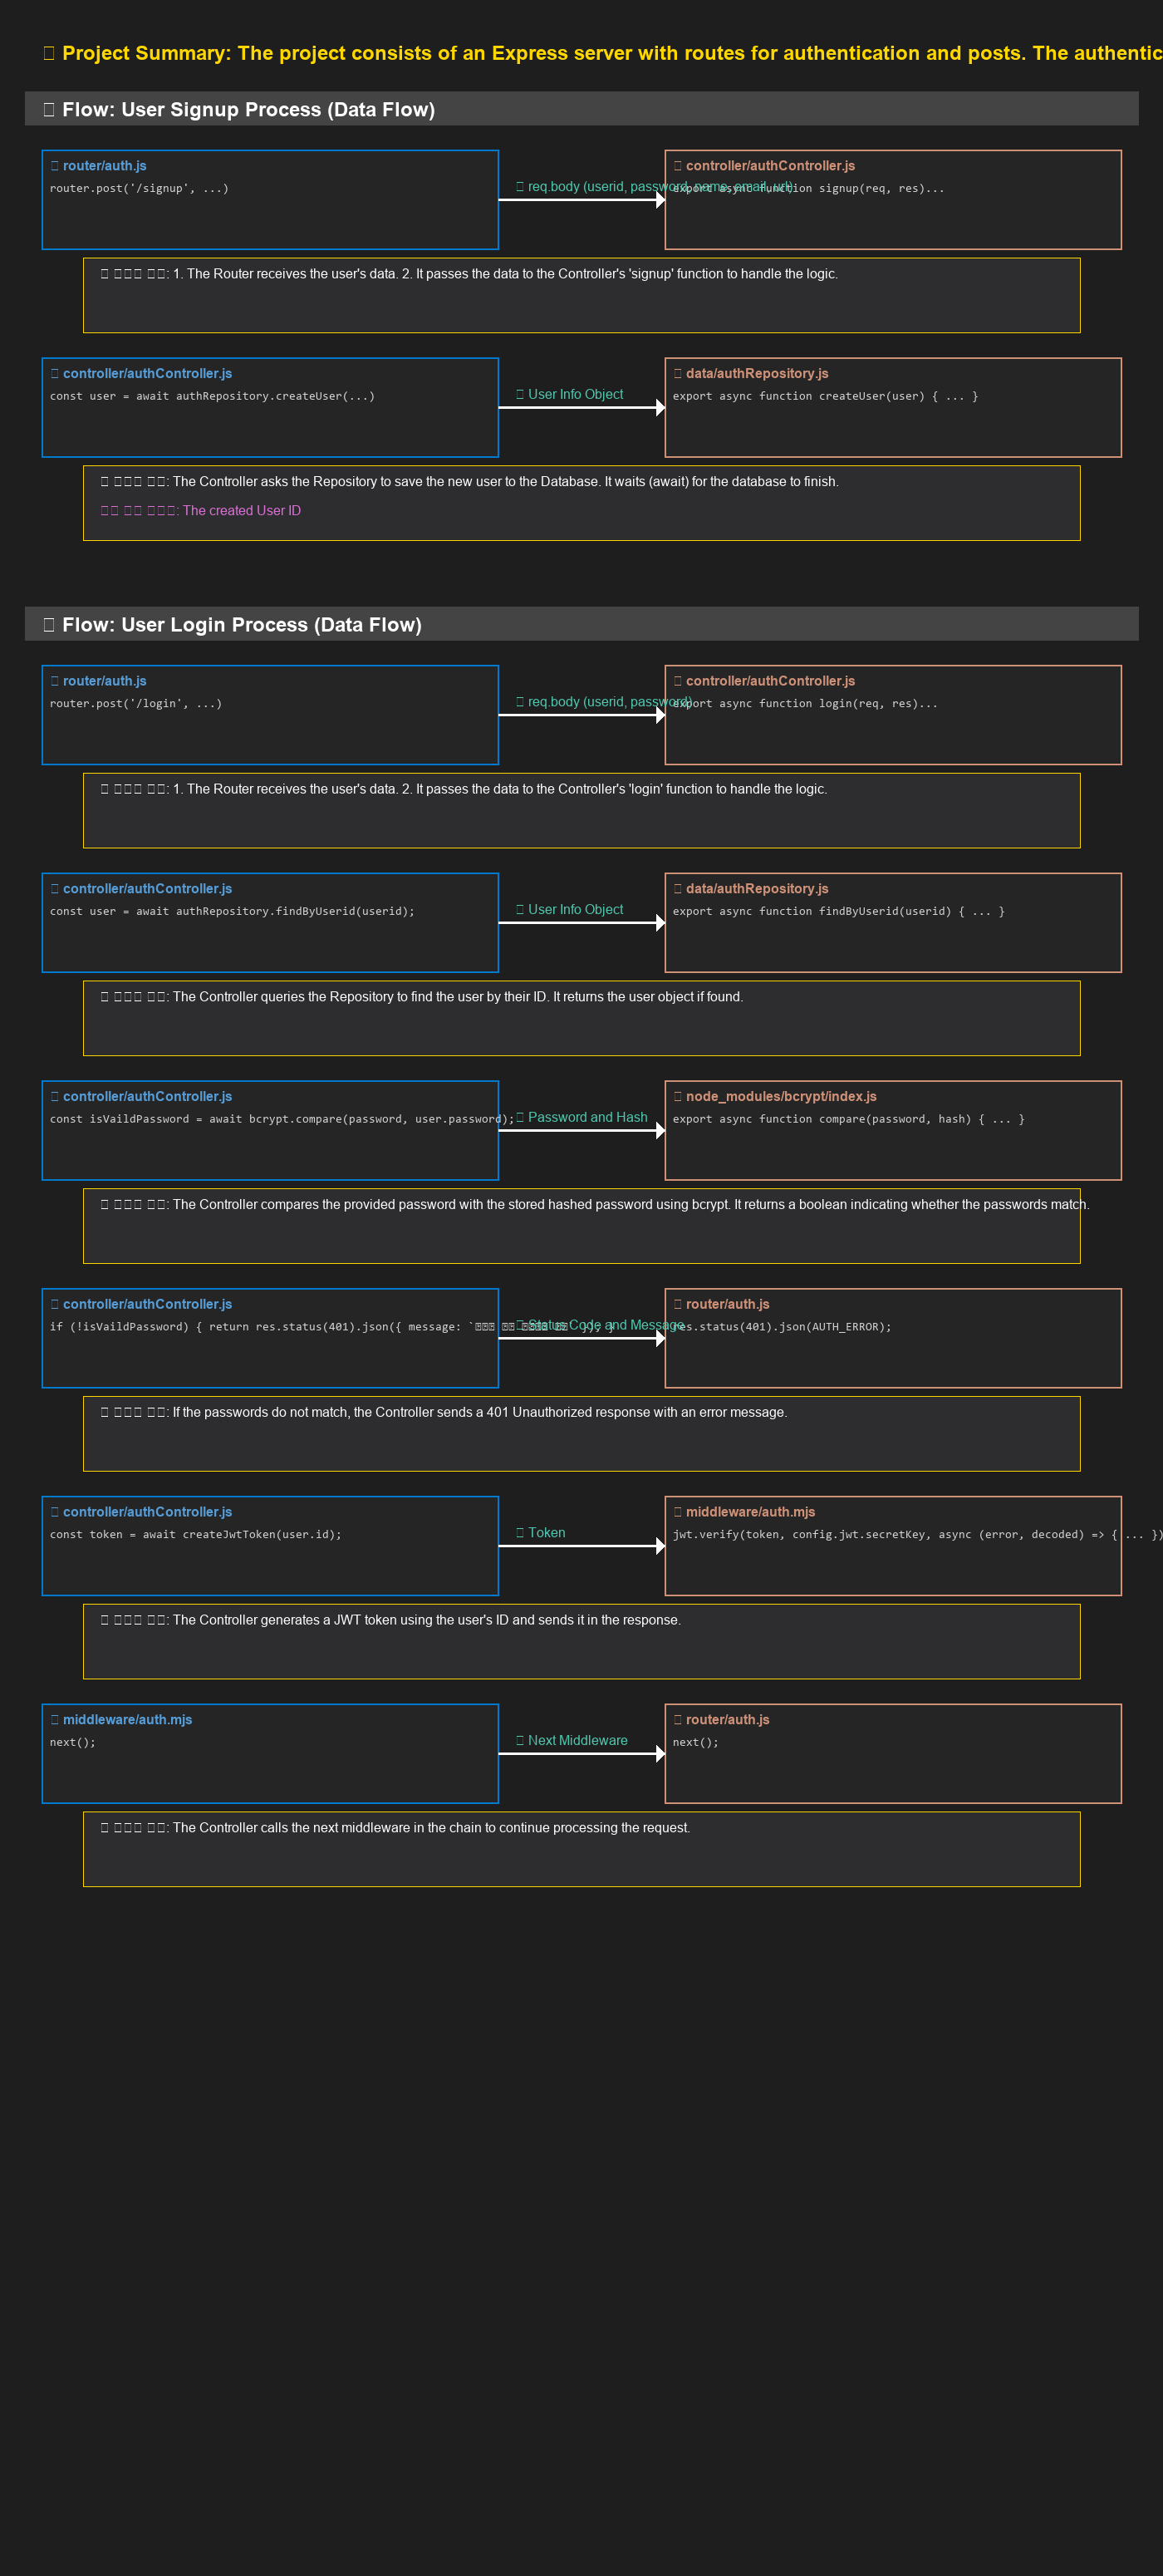

✨ 교육용 흐름도 저장 완료!


In [9]:
# Cell 8: 실행
print("🎨 시각화 시작...")
result_img = visualize_education_style()

if result_img:
    display(result_img)
    result_img.save("final_education_flow.png")
    print("✨ 교육용 흐름도 저장 완료!")
else:
    print("❌ 시각화 생성 실패")

In [5]:
# 디버깅: 입력 파일 확인
print("🔍 디버깅: 입력 파일 상태 확인")
print(f"INPUT_FILE 존재: {os.path.exists(INPUT_FILE)}")

if os.path.exists(INPUT_FILE):
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        content = f.read()
    
    print(f"파일 크기: {len(content)} bytes")
    print(f"첫 500자:\n{content[:500]}")
    
    # 파일 분할 테스트
    files = parse_files_from_context(content)
    print(f"\n파일 분할 결과: {len(files)}개 파일")
    for fname, fcontent in files.items():
        print(f"  - {fname}: {len(fcontent)} chars")
else:
    print("❌ project_full_context.txt 파일이 없습니다!")

🔍 디버깅: 입력 파일 상태 확인
INPUT_FILE 존재: True
파일 크기: 12721 bytes
첫 500자:
# Project Source Code Integration
# Target Directory: C:\Pyg\X\Server

### FILE: C:\Pyg\X\Server\app.mjs
------------------------------
import express from "express";
import postsRouter from "./router/posts.mjs";
import authRouter from "./router/auth.mjs";
import { config } from "./config.mjs";
import { connectDB } from "./db/database.mjs";
import cors from "cors";

// 미들웨어 순서가 맞아야됨
const app = express();

app.use(express.json());
app.

파일 분할 결과: 1개 파일
  - <full_context>: 12721 chars
